In [1]:
import itertools
import functools
import dataclasses
import packaging.version
from typing import List, Sequence, Set, Iterator, Optional

import libmambapy

import mamba_error_reporting as mer

# Problem definition

## PubGrub Example

The example given by Natalie Weizenbaum (image credits https://nex3.medium.com/pubgrub-2fb6470504f)

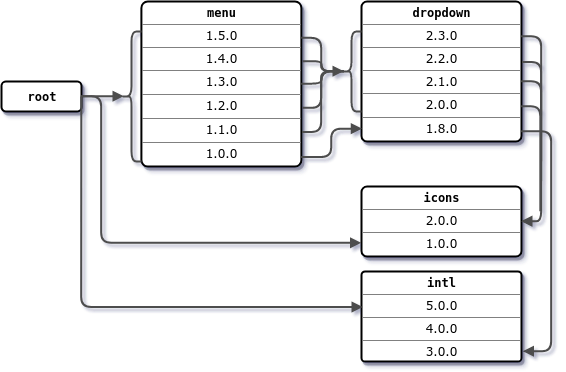

### Ideal output (from PubGrub)
```
Because dropdown >=2.0.0 depends on icons >=2.0.0 and root depends
  on icons <2.0.0, dropdown >=2.0.0 is forbidden.

And because menu >=1.1.0 depends on dropdown >=2.0.0, menu >=1.1.0
  is forbidden.

And because menu <1.1.0 depends on dropdown >=1.0.0 <2.0.0 which
  depends on intl <4.0.0, every version of menu requires intl
  <4.0.0.

So, because root depends on both menu >=1.0.0 and intl >=5.0.0,
  version solving failed.
```

# Conflict analysis

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", None)
pd.set_option("display.max_columns", None)

%matplotlib inline

In [3]:
solver, pool = mer.problems.create_scip()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - package pyscipopt-3.0.4b-py36ha03b18c_1 requires scip >=7.0.2,<8.0a0, but none of the providers can be installed
   


In [4]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

In [5]:
pbs

,type,source_id,source_is_pkg,dependency,dependency_id,target_id,target_is_pkg,explanation
0,SolverRuleinfo.SOLVER_RULE_JOB,2,True,pyscipopt <4.0,-2147282884,259,True,conflicting requests
1,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,185150,True,"scip >=7.0.2,<8.0a0",-2147461149,0,False,"package pyscipopt-3.0.4b-py36ha03b18c_1 requires scip >=7.0.2,<8.0a0, but none of the providers can be installed"
2,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,185151,True,"scip >=7.0.2,<8.0a0",-2147461149,0,False,"package pyscipopt-3.0.4b-py36ha03b18c_2 requires scip >=7.0.2,<8.0a0, but none of the providers can be installed"
3,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,185152,True,"scip >=7.0.2,<8.0a0",-2147461149,0,False,"package pyscipopt-3.0.4b-py36hc4f0c31_1 requires scip >=7.0.2,<8.0a0, but none of the providers can be installed"
4,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,185153,True,"scip >=7.0.2,<8.0a0",-2147461149,0,False,"package pyscipopt-3.0.4b-py36hc4f0c31_2 requires scip >=7.0.2,<8.0a0, but none of the providers can be installed"
...,...,...,...,...,...,...,...,...
117,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,234702,True,None,0,234694,True,cannot install both scip-8.0.1-hd6ea22a_1 and scip-7.0.2-h9e5b675_4
118,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,234702,True,None,0,234695,True,cannot install both scip-8.0.1-hd6ea22a_1 and scip-7.0.2-h9e5b675_5
119,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,234702,True,None,0,234696,True,cannot install both scip-8.0.1-hd6ea22a_1 and scip-7.0.2-hcabf41f_2
120,SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME,234702,True,None,0,234697,True,cannot install both scip-8.0.1-hd6ea22a_1 and scip-7.0.3-h9e5b675_0


In [6]:
deps

,dependency_id,solvable_id
0,-2147282884,185150
1,-2147282884,185151
2,-2147282884,185152
3,-2147282884,185153
4,-2147282884,185154
...,...,...
97,-2147461144,234698
98,-2147282885,234699
99,-2147282885,234700
100,-2147282885,234701


In [7]:
solvables

,name,version,build_string,build_number
id,,,,
2,21cmfast,3.0.2,py36h1af98f8_1,1
259,ace,6.5.11,h84b9e52_4,4
185150,pyscipopt,3.0.4b,py36ha03b18c_1,1
185151,pyscipopt,3.0.4b,py36ha03b18c_2,2
185152,pyscipopt,3.0.4b,py36hc4f0c31_1,1
...,...,...,...,...
234698,scip,7.0.3,hf5bcbcd_1,1
234699,scip,8.0.0,h9ff405d_1,1
234700,scip,8.0.0,hc3d86cf_0,0


In [8]:
import networkx as nx

def plot_dag(graph: nx.DiGraph, node_labels=None, edge_labels=None) -> None:
    plt.figure(figsize=(10, 6), dpi=300)

    # Position using levels
    pos = {}
    for level, nodes in enumerate(nx.topological_generations(graph)):
        nodes = sorted(nodes, key=lambda n: graph[n].get("name", "None"))
        pos.update({n: (x, -level - 0.2*(x%2)) for x, n in enumerate(nodes)})

    options = {"node_size": 800, "alpha": 0.5}
    nx.draw_networkx_nodes(graph, pos, node_color="blue", **options)
    nx.draw_networkx_edges(graph, pos, **options)

    if node_labels is not None:
        nx.draw_networkx_labels(graph, pos, node_labels, font_size=7)
    if edge_labels is not None:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=7)

    plt.tight_layout()
    plt.axis("off")
    plt.show()


def repr_pkg_info(p: libmambapy.PackageInfo) -> str:
    return f"{p.name}-{p.version}-{p.build_number}"

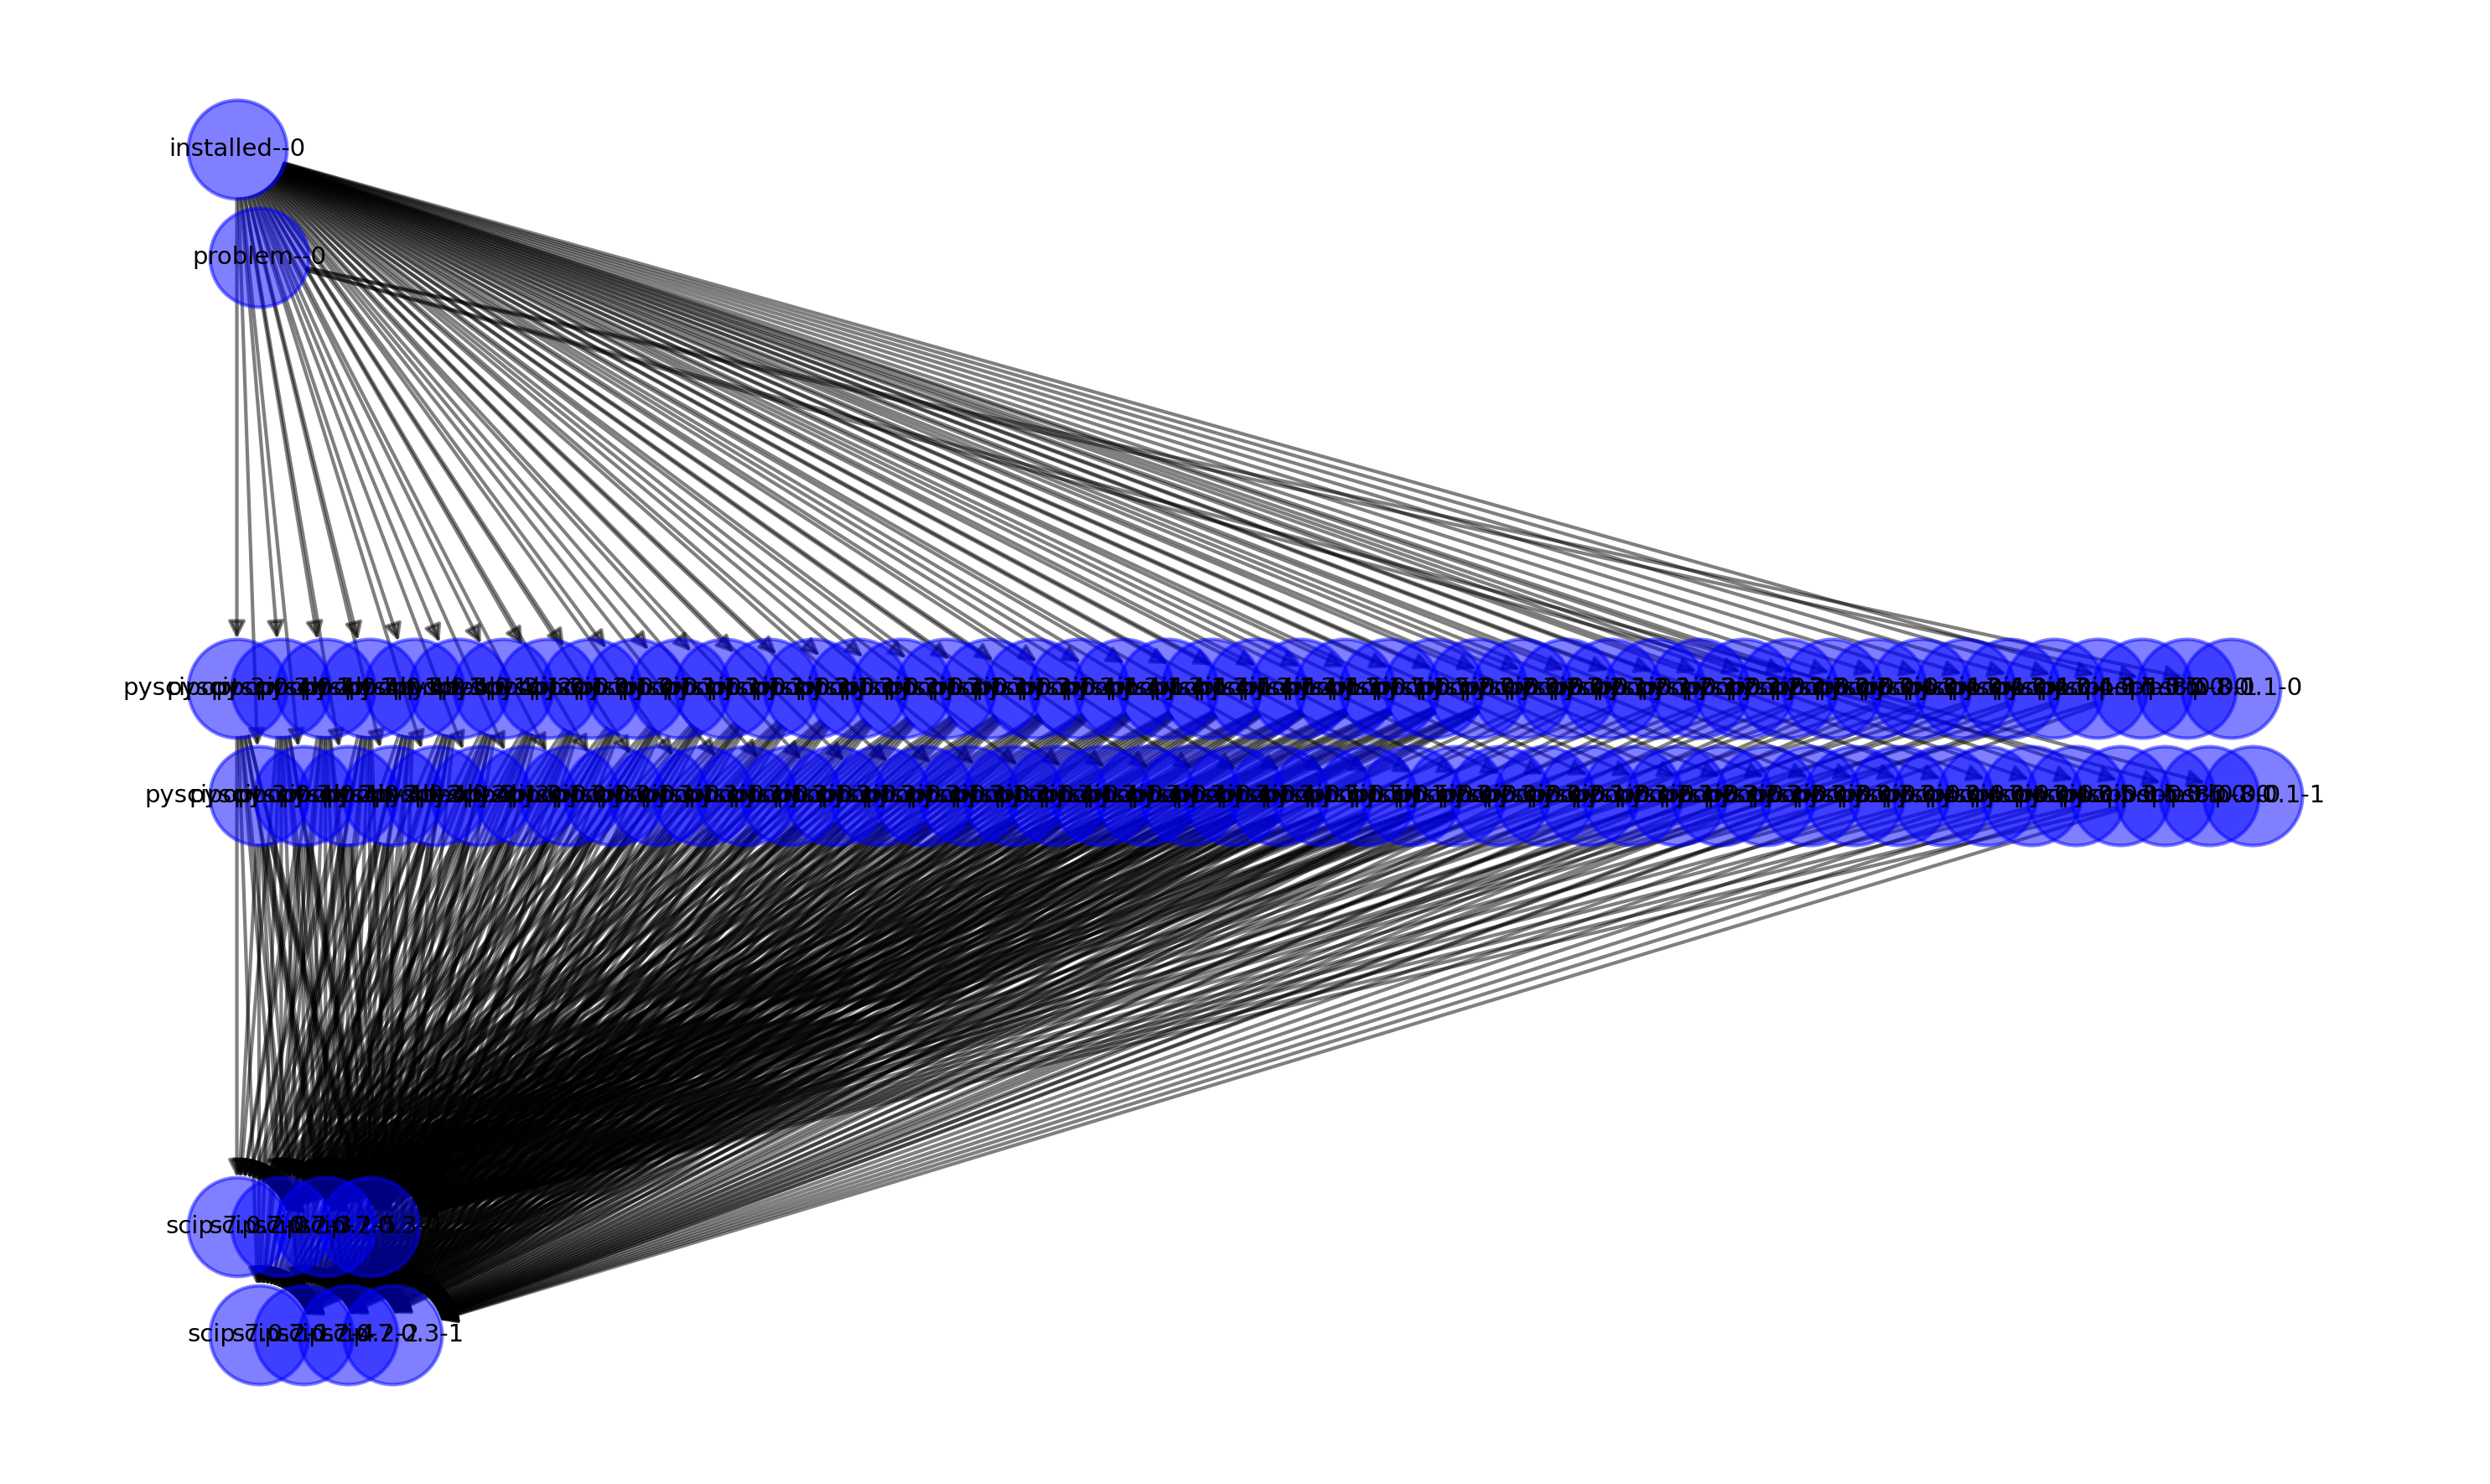

In [9]:
pb_data = mer.algorithm.ProblemData.from_libsolv(solver, pool)
plot_dag(pb_data.graph, node_labels={n: repr_pkg_info(pb_data.package_info[n]) for n in pb_data.graph.nodes})

In [10]:
g_compressed, groups = mer.algorithm.compress_graph(pb_data)

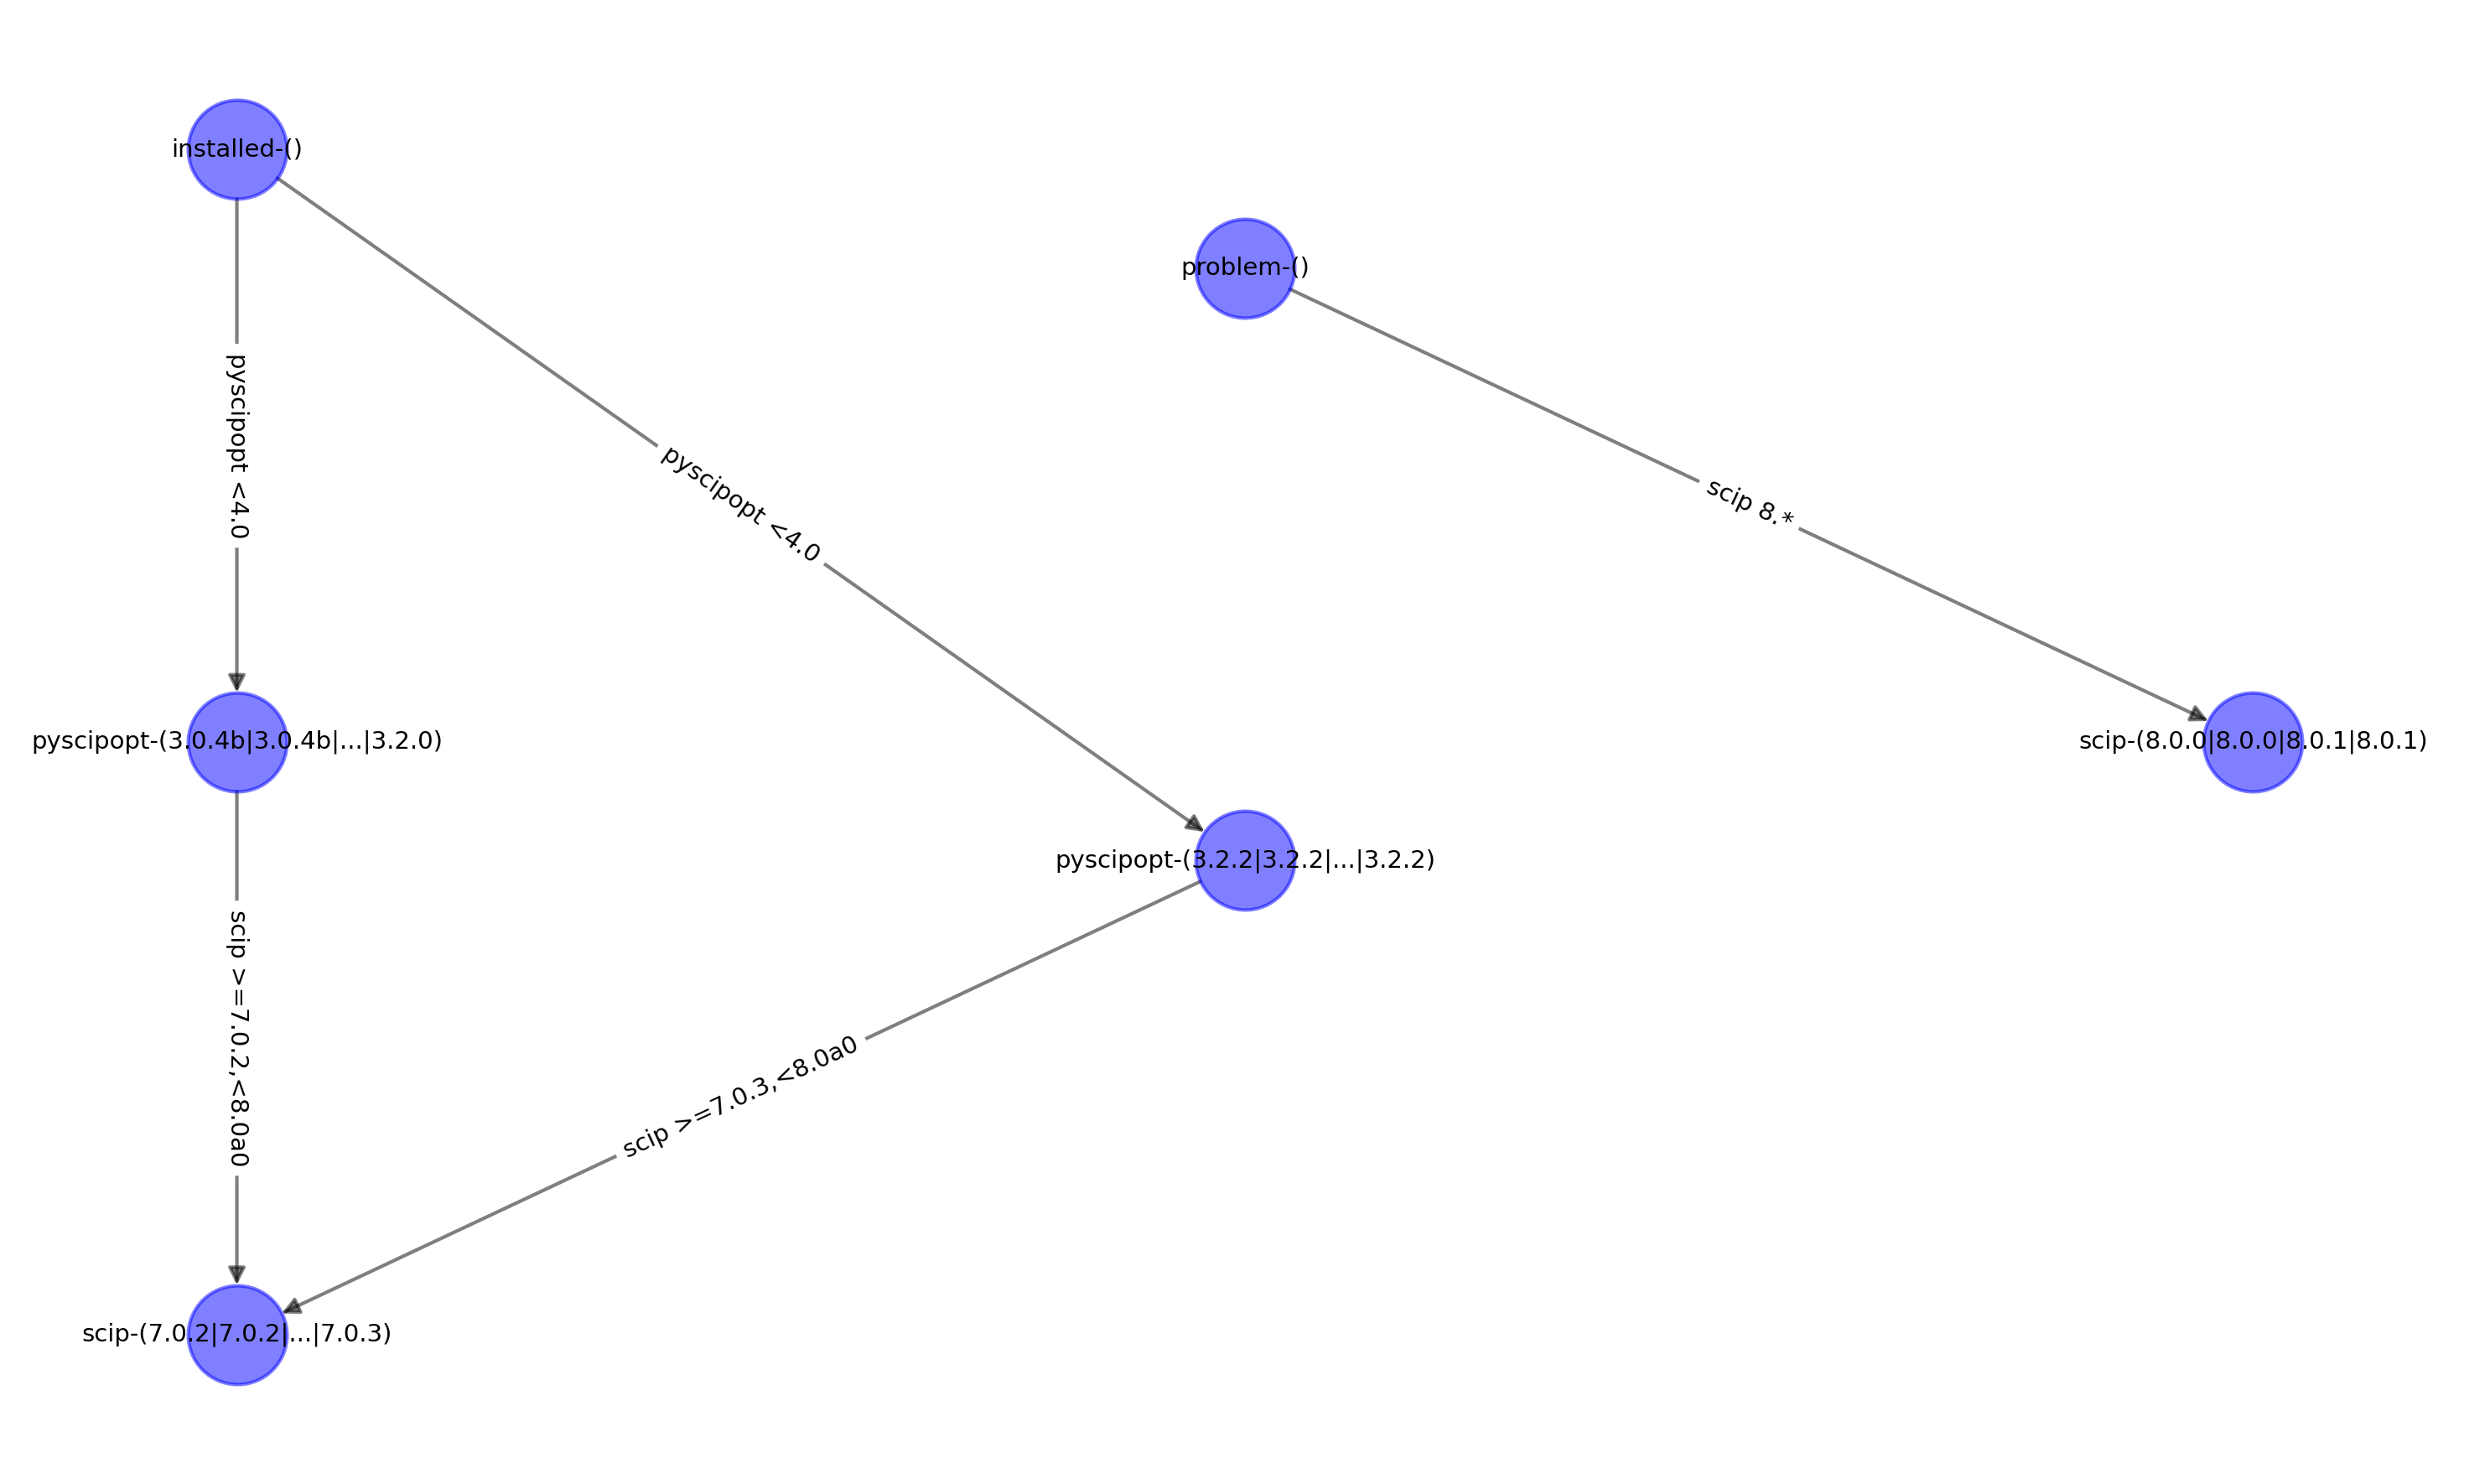

In [11]:
def graph_groups_labels(graph: nx.DiGraph, package_info, groups) -> dict:
    labels = {}
    for n in graph.nodes:
        solvs = [package_info.get(s) for s in groups.group_to_solv[n]]
        name = next(iter(solvs)).name
        versions = [p.version for p in solvs]
        # Truncate versions too long
        if len(versions) > 5:
            versions = versions[:2] + ["..."] + versions[-1:]
        labels[n] = f"{name}-(" + "|".join(versions) + ")"
    return labels


plot_dag(
    g_compressed,
    node_labels=graph_groups_labels(g_compressed, pb_data.package_info, groups),
    edge_labels={e: pb_data.dependency_names[attr["dependency_id"]] for e, attr in g_compressed.edges.items()},
)

In [12]:
import packaging.version


@dataclasses.dataclass
class Names:
    group_graph: nx.DiGraph
    pb_data: mer.algorithm.ProblemData
    groups: mer.algorithm.SolvableGroups
    
    def group_name(self, group_id) -> str:
        sample_solv_id = next(iter(self.groups.group_to_solv[group_id]))
        return self.pb_data.package_info[sample_solv_id].name
    
    def group_versions(self, group_id) -> list[str]:
        return list(set([pb_data.package_info[s].version for s in groups.group_to_solv[group_id]]))

    def group_versions_trunc(self, group_id, trunc_threshold: int = 5, trunc_show: int=2, trunc_str="...") -> list[str]:
        versions = self.group_versions(group_id)
        if len(versions) > trunc_threshold:
            return versions[:trunc_show] + [trunc_str] + versions[-trunc_show:]
        return versions
    
    def group_versions_range(self, group_id, range_sep="->") -> list[str]:
        parsed_versions = [packaging.version.parse(v) for v in self.group_versions(group_id)]
        return [str(min(parsed_versions)), range_sep, str(max(parsed_versions))]

    def edge_dependency_name(self, e) -> str:
        return self.pb_data.dependency_names[self.group_graph.edges[e]["dependency_id"]]
    
    def dependency_name(self, dep_id) -> str:
        return self.pb_data.dependency_names[dep_id]
    
        
    @functools.cached_property
    def same_name_groups(self):
        out = {}
        for p in self.pb_data.problems_by_type.get(libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_SAME_NAME, []):
            g_source = self.groups.solv_to_group[p.source_id]
            g_target = self.groups.solv_to_group[p.target_id]
            out[g_source] = g_target
            out[g_target] = g_source
        return out
    
    @functools.cached_property
    def nothing_provides_groups(self):
        out = {}
        for p in self.pb_data.problems_by_type.get(libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_NOTHING_PROVIDES_DEP, []):
            out.setdefault(self.groups.solv_to_group[p.source_id], set()).add(p.dep_id)
        return out

In [13]:
from typing import TypeVar, Iterable

T = TypeVar("T")

def pairwise(iterable: Iterable[T], last: T) -> Iterable[tuple[T, T]]:
    for a, b in itertools.pairwise(iterable):
        yield (a, b)
    yield (b, last)


@dataclasses.dataclass
class Explainer:
    names: Names
    indent: str = "  "
    
    def explain(self, path) -> str:
        message = []
        for (self.depth, self.dep_id_from, self.group_id, type, self.node_is_in_split), (next_depth, *_) in pairwise(path, last=(1, )):
            if self.dep_id_from is None:
                continue
            if next_depth == 1:
                term = "."
            elif next_depth < self.depth:
                term = ";"
            else:
                term = ""
            message += [
                self.indent * self.depth, 
                "".join(getattr(self, f"explain_{type.value}")()),
                term,
                "\n",
            ]

        message.pop()  # Last line break 
        return "".join(message)
    
    @property
    def pkg_name(self) -> str:
        return self.names.group_name(self.group_id)
    
    @property
    def dep_name(self) -> str:
        return self.names.dependency_name(self.dep_id_from)

    @property
    def pkg_repr(self) -> str:
        if self.node_is_in_split:
            return "{name} [{versions}]".format(
                name=self.pkg_name,
                versions="|".join(self.names.group_versions_trunc(self.group_id))
            )
        return self.dep_name
            
    @property
    def nothing_provides_name(self) -> str | None:
        dep_ids = self.names.nothing_provides_groups.get(self.group_id)
        if dep_ids is not None:
            return self.names.pb_data.dependency_names[next(iter(dep_ids))]
        return None
        
        
class ProblemExplainer(Explainer):
    def explain_diving(self) -> tuple[str]:
        return (
            "This implies that " if self.depth <= 1 else "",
            self.pkg_repr,
            " cannot be installed because it requires" if self.depth <= 1 else ", which requires",
        )

    def explain_split(self):
        return (
            "This implies that " if self.depth <= 1 else "",
            self.dep_name,
            " cannot be installed because" if self.depth <= 1 else " for which",
            " none of the following versions can be installed"
        )

    def explain_leaf(self):
        red = lambda msg: mer.color.color(msg, fg="red", style="bold")
        message = ("This implies that " if self.depth <= 1 else "", self.pkg_repr)
        if self.group_id in self.names.same_name_groups:
            return message + (
                " cannot be installed because it conflicts" if self.depth <= 1 else ", which conflicts",
                f" with the installed versions of {red(self.pkg_name)}"
            )
        elif self.nothing_provides_name is not None:
            return message + (
                " cannot be installed because it requires" if self.depth <= 1 else ", which requires",
                f" the non-existent package {red(self.nothing_provides_name)}"
            )
        else:
            return message + (
                "" if self.depth <= 1 else ", which",
                " cannot be installed for an unknown reason"
            )
    
    def explain_visited(self):
        return (
            self.pkg_repr,
            "" if self.depth <= 1 else ", which",
            " cannot be installed (as previously explained)"
        )
    
    
class InstallExplainer(Explainer):
    def explain_diving(self) -> tuple[str]:
        return (         
            "A package satisfying " if self.depth <= 1 else "",
            self.pkg_repr,
            " is requested, and it requires" if self.depth <= 1 else ", which requires",
        )

    def explain_split(self):
        return (
            "A package satisfying " if self.depth <= 1 else "",
            self.dep_name,
            " is requested, so one of the following versions must be installed",
        )

    def explain_leaf(self):
        green = lambda msg: mer.color.color(msg, fg="green", style="bold")
        return (
            "A package satisfying " if self.depth <= 1 else "",
            green(self.pkg_repr),
            " is requested and could be installed" if self.depth <= 1 else ", which could be installed",
        )

    def explain_visited(self):
        return (
            self.pkg_repr,
            "" if self.depth <= 1 else ", which",
            " could be installed (as previously explained)"
        )

    
# Groups may be superset of the dependencies
def make_dep_id_to_groups(graph: nx.DiGraph):
    groups = {}
    for (_, s), attr in graph.edges.items():
        groups.setdefault(attr["dependency_id"], set()).add(s)
    return groups


def explain(graph_compressed, pb_data, groups):
    names = Names(graph_compressed, pb_data, groups)

    install_root = groups.solv_to_group[-1]
    problem_root = groups.solv_to_group[0]

    dep_id_to_groups = make_dep_id_to_groups(graph_compressed)
    is_multi = {dep_id: len(group) > 1 for dep_id, group in dep_id_to_groups.items()}
    
    # FIXME This won't work if there are mutliple problem dependencies
    # Could that be the case? -> Make tests
    problem_name = pb_data.dependency_names[graph_compressed.edges[next(iter(graph_compressed.out_edges(problem_root)))]["dependency_id"]]
    problem_name = mer.color.color(problem_name, fg="red", style="bold")
    print(f"Error: Could not install any versions from requested package {problem_name}.\n")
    
    inst_explainer = InstallExplainer(names)
    print(
        inst_explainer.explain(
            mer.algorithm.explanation_path(graph_compressed, install_root, set(), is_multi, explore_all=True)
        )
    )

    print()
    pb_explainer = ProblemExplainer(names)
    print(
        pb_explainer.explain(
            mer.algorithm.explanation_path(graph_compressed, problem_root, set(), is_multi, explore_all=False)
        )
    )

In [14]:
explain(g_compressed, pb_data, groups)

Error: Could not install any versions from requested package scip 8.*.

  A package satisfying pyscipopt <4.0 is requested, so one of the following versions must be installed
    pyscipopt [3.2.1|3.2.2|3.5.0|3.4.0|3.3.0], which requires
      scip >=7.0.3,<8.0a0, which could be installed;
    pyscipopt [3.1.1|3.0.4b|...|3.1.5|3.1.0], which requires
      scip >=7.0.2,<8.0a0, which could be installed.

  This implies that scip 8.* cannot be installed because it conflicts with the installed versions of scip.
